BERT

In [ ]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import string
import nltk
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset
from transformers import AutoTokenizer, BertModel
from transformers import AutoModelForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
import random
import os
import matplotlib.pyplot as plt
from keras.models import load_model, save_model

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_traveloka = pd.read_csv('/content/gdrive/MyDrive/Dataset_Traveloka/datatraveloka.csv')
data_traveloka = data_traveloka.drop(['score'], axis=1)
data_traveloka['Label'] = data_traveloka['Label'].replace('Netral', 'Negatif')
data_traveloka = data_traveloka.groupby('Label').head(600)
data_traveloka.Label.value_counts()

Positif    600
Negatif    600
Name: Label, dtype: int64

In [ ]:
possible_labels = data_traveloka.Label.unique()

In [ ]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [ ]:
data = data_traveloka.copy()
data['label'] = data.Label.replace(label_dict)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1573
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1200 non-null   object
 1   Label    1200 non-null   object
 2   label    1200 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 37.5+ KB


In [ ]:
def clean_text(text):
    cleaned_text = text.lower()
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)
    return cleaned_text

In [ ]:
with open('/content/clean.pkl', 'wb') as f:
    pickle.dump(clean_text, f)

In [ ]:
data['cleaned_comment'] = data['content'].apply(clean_text)

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if not token.isnumeric()]
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in stopwords.words('indonesian')]
    return ' '.join(tokens)

In [ ]:
with open('/content/preprocess.pkl', 'wb') as f:
    pickle.dump(preprocess_text, f)

In [ ]:
data['preprocessed_comment'] = data['cleaned_comment'].apply(preprocess_text)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data.index.values,
                                                  data.label.values,
                                                  test_size=0.15,
                                                  random_state=17,
                                                  stratify=data.label.values)

In [ ]:
data['data_type'] = ['not_set']*data.shape[0]

In [ ]:
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

In [ ]:
data.groupby(['preprocessed_comment', 'label', 'data_type']).count()

,,,content,Label,cleaned_comment
preprocessed_comment,label,data_type,,,
,0,train,1,1,1
1harga mahal aplikasi yg selisih lumayan promo discount hotel tampil man doank harga 2kl traveloka sangsi penginapanhotel yg akomodasi batal pesan eticket evoucher terbittraveloka jgn bela penginapanhotel yg mengakomodasikanmembatalkan pesanankarena alami batal,1,train,1,1,1
1x sen hotel fiktifhotel palsu 1x sen hotel lg suruh bayar suruh nambah x sen bus ga bantu reschedule tanggal,1,train,1,1,1
2hari aplikasi mas koneksi internet setbil,1,train,1,1,1
2tahun ga pke traveloka corona limit paylater gak rang pdhl jarang pake jg gilir ganti trinusa traveindo caturnusa sejahtera uda nelpon tiba2 suruh bayar cepet2 pdhl ga ramah kek deptcollector limit tb2 diturunin limit ga mslh sebenernya cm kecewa aja pdhl akun bgt uda 5tahun lbh pke traveloka busuk,1,train,1,1,1
...,...,...,...,...,...
ya kali beli tiket kereta habis,0,val,1,1,1
ya sistem traveloka pas cek detail pesan tiket gagal muat koneksi internet koneksi internet bagus buka aplikasi lancar buka apk traveloka lancar pas cek detail tiket aka kek gitu aneh apk nyesal dah pesan tiket,1,val,1,1,1
yg cepat unt traveling,0,train,1,1,1


In [ ]:
data_json_path = '/content/Traveloka.json'
data.to_json(data_json_path, orient='records', lines=True)

In [ ]:
from transformers import pipeline

pipe = pipeline("feature-extraction", model="cahya/bert-base-indonesian-1.5G")

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
model_name='cahya/bert-base-indonesian-1.5G'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
train_comments = data[data.data_type == 'train'].preprocessed_comment.values.tolist()
val_comments = data[data.data_type == 'val'].preprocessed_comment.values.tolist()

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_comments,
    add_special_tokens=True,
    return_attention_mask=True,
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_comments,
    add_special_tokens=True,
    return_attention_mask=True,
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type == 'train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type == 'val'].label.values)

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
len(dataset_train)

1020

In [ ]:
len(dataset_val)

180

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("cahya/bert-base-indonesian-1.5G",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 32

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
f1_score_values = []

accuracy_values = []

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    val_accuracy = (predictions.argmax(axis=1) == true_vals).mean()
    tqdm.write(f'Accuracy: {val_accuracy}')

    accuracy_values.append(val_accuracy)

    f1_score_values.append(val_f1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.46908847987651825
Validation loss: 0.31075961391131085
F1 Score (Weighted): 0.8598611067858365
Accuracy: 0.8611111111111112


Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.28588403202593327
Validation loss: 0.2344782936076323
F1 Score (Weighted): 0.9054125065685759
Accuracy: 0.9055555555555556


Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.21882105013355613
Validation loss: 0.23540148263176283
F1 Score (Weighted): 0.9108359133126934
Accuracy: 0.9111111111111111


Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.1687247302616015
Validation loss: 0.2433583289384842
F1 Score (Weighted): 0.8996904024767802
Accuracy: 0.9


Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.13619595166528597
Validation loss: 0.2500924902657668
F1 Score (Weighted): 0.9054826254826256
Accuracy: 0.9055555555555556


Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.09406327232136391
Validation loss: 0.2781166359782219
F1 Score (Weighted): 0.9055526405135961
Accuracy: 0.9055555555555556


Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.07443893566960469
Validation loss: 0.2949269426365693
F1 Score (Weighted): 0.9221837944664031
Accuracy: 0.9222222222222223


Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.06870333681581542
Validation loss: 0.34156494385873276
F1 Score (Weighted): 0.8883928571428571
Accuracy: 0.8888888888888888


Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.06247008079662919
Validation loss: 0.3091107603783409
F1 Score (Weighted): 0.9221837944664031
Accuracy: 0.9222222222222223


Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.04679573779867496
Validation loss: 0.3230239183952411
F1 Score (Weighted): 0.8998020781791193
Accuracy: 0.9


In [ ]:
torch.cuda.empty_cache()

model.save_pretrained("BrainWaves")
tokenizer.save_pretrained("BrainWaves")

model.save_pretrained("/content/drive/MyDrive/BrainWaves")
tokenizer.save_pretrained("/content/drive/MyDrive/BrainWaves")

('/content/drive/MyDrive/BrainWaves/tokenizer_config.json',
 '/content/drive/MyDrive/BrainWaves/special_tokens_map.json',
 '/content/drive/MyDrive/BrainWaves/vocab.txt',
 '/content/drive/MyDrive/BrainWaves/added_tokens.json',
 '/content/drive/MyDrive/BrainWaves/tokenizer.json')

In [ ]:
model.save_pretrained("/content/gdrive/MyDrive/BrainWaves")
tokenizer.save_pretrained("/content/gdrive/MyDrive/BrainWaves")

('/content/gdrive/MyDrive/BrainWaves/tokenizer_config.json',
 '/content/gdrive/MyDrive/BrainWaves/special_tokens_map.json',
 '/content/gdrive/MyDrive/BrainWaves/vocab.txt',
 '/content/gdrive/MyDrive/BrainWaves/added_tokens.json',
 '/content/gdrive/MyDrive/BrainWaves/tokenizer.json')

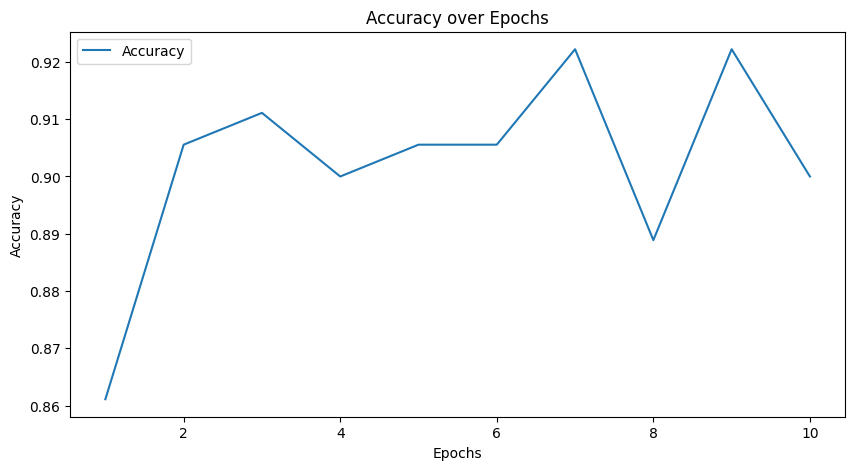

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), accuracy_values, label='Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
best_accuracy = max(accuracy_values)
best_accuracy_index = accuracy_values.index(best_accuracy) + 1
model_save_path_best_acc = f'/content/drive/MyDrive/BrainWaves/Best_Model.pkl'
with open(model_save_path_best_acc, 'wb') as f:
    pickle.dump(model, f)

In [ ]:
best_accuracy = max(accuracy_values)
best_accuracy_index = accuracy_values.index(best_accuracy) + 1
model_save_path_best_acc = f'/content/gdrive/MyDrive/BrainWaves/Traveloka_Best_Accuracy.pkl'
with open(model_save_path_best_acc, 'wb') as f:
    pickle.dump(model, f)

In [ ]:
model_path = "/content/drive/MyDrive/BrainWaves"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
with open('/content/clean.pkl', 'rb') as f:
    clean_text = pickle.load(f)

with open('/content/preprocess.pkl', 'rb') as f:
    preprocess_text = pickle.load(f)

In [ ]:
def classify_text(input_text):
    cleaned_text = clean_text(input_text)
    preprocessed_text = preprocess_text(cleaned_text)

    inputs = tokenizer(preprocessed_text, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    predicted_class = torch.argmax(outputs.logits).item()

    label_dict_inverse = {v: k for k, v in label_dict.items()}
    predicted_label = label_dict_inverse[predicted_class]

    return predicted_label

In [ ]:
user_input = input("Masukkan Sentimen Anda: ")
result = classify_text(user_input)
print("Prediksi Sentimen:", result)

Masukkan Sentimen Anda: layanan yang tersedia cukup lengkap, sehingga memudahkan saya untuk menggunakan aplikasinya
Prediksi Sentimen: Positif


In [ ]:
user_input = input("Masukkan Sentimen Anda: ")
result = classify_text(user_input)
print("Prediksi Sentimen:", result)

Masukkan Sentimen Anda: jelek banget, pelayanannya lambat dan tidak bisa refund
Prediksi Sentimen: Negatif


SVM

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import zipfile
from gensim.models import Word2Vec
from sklearn.utils import resample

In [ ]:
df = pd.read_csv('/content/cleaned_datatraveloka.csv')
df.head()

,content,Label,label,comment,cleaned_comment,preprocessed_comment
0,"menjadi salah satu aplikasi kesukaan,karna say...",Positif,0,"menjadi salah satu aplikasi kesukaan,karna say...",menjadi salah satu aplikasi kesukaankarna saya...,salah aplikasi kesukaankarna suka jalan2 jd se...
1,Sangat membantu segala urusan saya...,Positif,0,sangat membantu segala urusan saya...,sangat membantu segala urusan saya,bantu urus
2,"Wow aplikasinya sangat membantu sekali, memuda...",Positif,0,"wow aplikasinya sangat membantu sekali, memuda...",wow aplikasinya sangat membantu sekali memudah...,wow aplikasi bantu mudah mes tiket hotel tiket...
3,cepat..tdk ribet..,Positif,0,cepat..tdk ribet..,cepattdk ribet,cepattdk ribet
4,"Ga tau mo ngomong apa,, mo pesan hotel aga sus...",Negatif,1,"ga tau mo ngomong apa,, mo pesan hotel aga sus...",ga tau mo ngomong apa mo pesan hotel aga susah...,ga tau mo ngomong mo pesan hotel aga susah mas...


In [ ]:
df.isna().sum()

content                 0
Label                   0
label                   0
comment                 0
cleaned_comment         0
preprocessed_comment    1
dtype: int64

In [ ]:
df['preprocessed_comment'].fillna("", inplace=True)

In [ ]:
df.isna().sum()

content                 0
Label                   0
label                   0
comment                 0
cleaned_comment         0
preprocessed_comment    0
dtype: int64

In [ ]:
label_counts = df['label'].value_counts()
label_counts

1    4841
0    4550
2     609
Name: label, dtype: int64

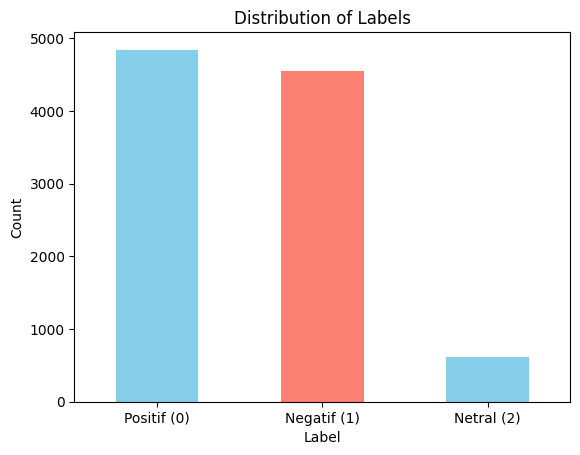

In [ ]:
label_counts = df['label'].value_counts()
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1,2], ['Positif (0)', 'Negatif (1)', 'Netral (2)'], rotation=0)
plt.show()

In [ ]:
label_0 = df[df['label'] == 0]
label_1 = df[df['label'] == 1]
label_2 = df[df['label'] == 2]

In [ ]:
label_2_oversampled = resample(label_2,
                                replace=True,
                                n_samples=len(label_0),
                                random_state=42)

In [ ]:
data = pd.concat([label_0, label_1, label_2_oversampled])

In [ ]:
new_label = data['label'].value_counts()
new_label

1    4841
0    4550
2    4550
Name: label, dtype: int64

In [ ]:
model = "/content/drive/MyDrive/Dataset/idwiki_word2vec_300"
with zipfile.ZipFile("/content/drive/MyDrive/Dataset/idwiki_word2vec_300.zip", 'r') as zip_ref:
    zip_ref.extractall(model)

In [ ]:
sample_words = ["hotel", "tiket", "bantu", "aplikasi"]
model_w2v_path = [f for f in os.listdir(model) if f.endswith('.model')][0]
model_w2v = Word2Vec.load(os.path.join(model, model_w2v_path))

In [ ]:
sample_vectors = {word: model_w2v.wv[word] for word in sample_words if word in model_w2v.wv}
sample_vectors

{'hotel': array([-2.12708354e+00, -1.53236520e+00,  1.07584989e+00, -1.27481353e+00,
         1.82618582e+00, -9.66236413e-01, -1.04648793e+00, -8.26403439e-01,
        -3.14563930e-01,  1.85522866e+00,  9.56158578e-01, -1.81878459e+00,
         1.88431060e+00, -8.51626396e-01, -4.48387116e-01, -8.59268188e-01,
        -2.12976861e+00, -2.18907380e+00,  3.47390819e+00,  9.72543836e-01,
         3.27071357e+00,  4.16699320e-01,  3.71807605e-01,  1.15369833e+00,
         7.23692417e-01,  2.73822808e+00,  1.68343735e+00, -1.46742868e+00,
        -1.94497108e+00, -1.81000912e+00, -1.01670110e+00,  2.06485614e-02,
        -9.42274988e-01,  2.71129817e-01, -1.73921382e+00,  3.85843843e-01,
        -5.24513721e-01,  1.30773628e+00, -7.41318703e-01, -1.97710979e+00,
        -8.15449953e-01,  2.03273296e+00,  5.10702968e-01, -7.16399252e-01,
        -1.60573512e-01, -3.47981364e-01,  1.53084540e+00,  1.70017239e-02,
         9.76309299e-01,  1.23327696e+00, -1.46006930e+00, -1.82968903e+00,
   

In [ ]:
def comment_to_vec(comment, model_w2v):
    words = comment.split()
    vecs = [model_w2v.wv[word] for word in words if word in model_w2v.wv]
    if not vecs:
        return np.zeros(model_w2v.vector_size)
    return np.mean(vecs, axis=0)

In [ ]:
data['vec_id'] = data['preprocessed_comment'].apply(lambda x: comment_to_vec(x, model_w2v))

In [ ]:
X = np.stack(data['vec_id'].to_numpy())
y = data['label'].to_numpy()

In [ ]:
X = np.stack(data['vec_id'].to_numpy())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
svm_id = SVC(kernel='linear', probability=True)
svm_id.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
y_pred = svm_id.predict(X_test)
y_pred

array([1, 2, 2, ..., 0, 0, 1])

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7099318752240946

In [ ]:
classification = classification_report(y_test, y_pred)
print(classification)

              precision    recall  f1-score   support

           0       0.80      0.75      0.78       930
           1       0.74      0.66      0.70       999
           2       0.61      0.72      0.66       860

    accuracy                           0.71      2789
   macro avg       0.72      0.71      0.71      2789
weighted avg       0.72      0.71      0.71      2789



In [ ]:
confusion = confusion_matrix(y_test, y_pred)

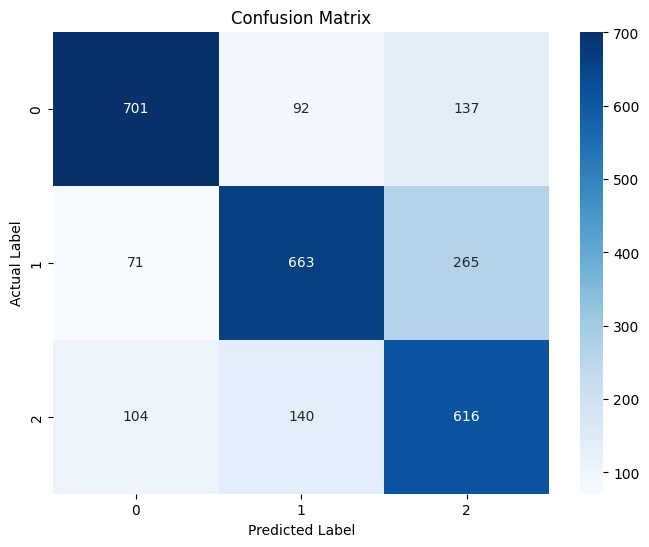

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_prob = svm_id.predict_proba(X_test)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

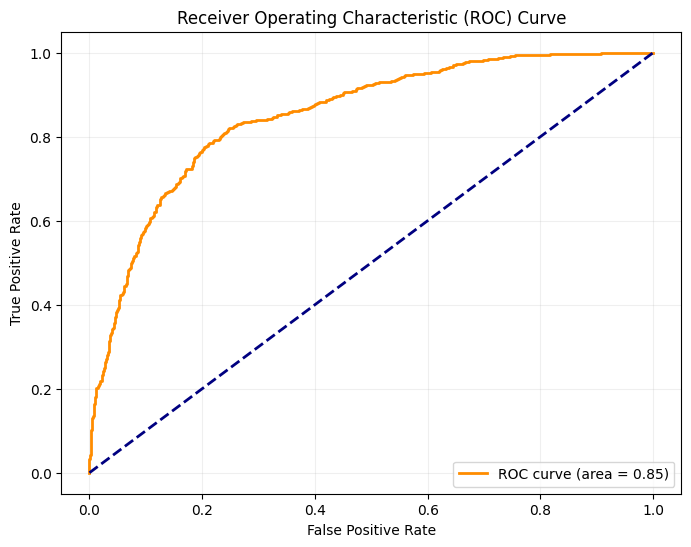

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

LSTM

In [ ]:
import re
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Embedding,LSTM
from keras.utils import to_categorical

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Dataset_Traveloka/datatraveloka.csv')
df = df.drop(['score'], axis=1)
df['Label'] = df['Label'].replace('Netral', 'Negatif')
df = df.groupby('Label').head(1500)
df.Label.value_counts()

Positif    1500
Negatif    1500
Name: Label, dtype: int64

In [ ]:
df.head(5)

,content,Label
0,"menjadi salah satu aplikasi kesukaan,karna say...",Positif
1,Sangat membantu segala urusan saya...,Positif
2,"Wow aplikasinya sangat membantu sekali, memuda...",Positif
3,cepat..tdk ribet..,Positif
4,"Ga tau mo ngomong apa,, mo pesan hotel aga sus...",Negatif


In [ ]:
df = df.copy()
df["Label"].replace({"Positif":1, "Negatif":0}, inplace=True)
df.head(5)

,content,Label
0,"menjadi salah satu aplikasi kesukaan,karna say...",1
1,Sangat membantu segala urusan saya...,1
2,"Wow aplikasinya sangat membantu sekali, memuda...",1
3,cepat..tdk ribet..,1
4,"Ga tau mo ngomong apa,, mo pesan hotel aga sus...",0


In [ ]:
def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

In [ ]:
df['comment'] = df['content'].str.lower().astype(str)
df['cleaned_comment'] = df['comment'].apply(clean_text)

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if not token.isnumeric()]
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in stopwords.words('indonesian')]
    return ' '.join(tokens)

In [ ]:
df['preprocessed_comment'] = df['cleaned_comment'].apply(preprocess_text)

In [ ]:
x = np.array(df["preprocessed_comment"].values)
y = np.array(df["Label"].values)

In [ ]:
vocalbulary_size = 5000
onehot_encoded = [one_hot(preprocessed_comment,vocalbulary_size) for preprocessed_comment in x]

max_length=500
x_padded = pad_sequences(onehot_encoded,max_length,padding="post")

x_train, x_test, y_train, y_test = train_test_split(x_padded,y,test_size=0.2)

In [ ]:
model = Sequential()
embeded_vector_size = 35
model.add(Embedding(vocalbulary_size,embeded_vector_size,input_length=max_length))
model.add(LSTM(100))
model.add(Dense(1,activation="sigmoid"))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

print(model.summary())
print("Model Creation Completed !")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 35)           175000    
                                                                 
 lstm (LSTM)                 (None, 100)               54400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 229501 (896.49 KB)
Trainable params: 229501 (896.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model Creation Completed !


In [ ]:
class MyThresholdCallback(Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True
            model_name = ("Traveloka_sentiment_analysis"+str(val_acc))
            model.save(model_name)

model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),callbacks=[MyThresholdCallback(threshold=0.87)])

model.save("Traveloka_sentiment_analysis")

Epoch 1/100
75/75 [==============================] - 15s 161ms/step - loss: 0.6937 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5150
Epoch 2/100
75/75 [==============================] - 6s 82ms/step - loss: 0.6936 - accuracy: 0.4921 - val_loss: 0.6932 - val_accuracy: 0.4850
Epoch 3/100
75/75 [==============================] - 6s 81ms/step - loss: 0.6935 - accuracy: 0.5021 - val_loss: 0.6936 - val_accuracy: 0.4850
Epoch 4/100
75/75 [==============================] - 3s 33ms/step - loss: 0.6933 - accuracy: 0.5038 - val_loss: 0.6937 - val_accuracy: 0.4850
Epoch 5/100
75/75 [==============================] - 3s 47ms/step - loss: 0.6934 - accuracy: 0.4754 - val_loss: 0.6935 - val_accuracy: 0.4850
Epoch 6/100
75/75 [==============================] - 2s 28ms/step - loss: 0.6933 - accuracy: 0.5038 - val_loss: 0.6935 - val_accuracy: 0.4850
Epoch 7/100
75/75 [==============================] - 2s 32ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6936 - val_accuracy: 0.4850
Epoc

In [ ]:
trained_model = load_model("/content/Traveloka_sentiment_analysis")
predicted = trained_model.predict(x_test)[2]

sentiment = 1 if predicted > 0.6 else 0

print("PREDICTED : ",sentiment)
print("ACTUAL : ",y_test[2])

19/19 [==============================] - 1s 14ms/step
PREDICTED :  0
ACTUAL :  0


In [ ]:
def get_sentiment(sentence: str):
    if isinstance(sentence, (str)):
        pass
    else:
        raise Exception("Teks yang diinputkan harus berupa string")

    sentence = sentence.lower()

    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''

    for word in sentence:
        if word in punc:
            sentence = sentence.replace(word, " ")

    from keras.models import load_model

    trained_model = load_model("/content/Traveloka_sentiment_analysis")

    predicted = trained_model.predict(x_test)[2]
    sentiment = 1 if predicted > 0.6 else 0

    if sentiment == 1:
        print("Positif")
    else:
        print("Negatif")

    return sentiment


get_sentiment("Aplikasinya sangat membantu dalam pemesanan tiket secara instan dan tidak ribet")

19/19 [==============================] - 1s 13ms/step
Negatif


0

In [ ]:
def get_sentiment(sentence: str):
    if isinstance(sentence, (str)):
        pass
    else:
        raise Exception("Teks yang diinputkan harus berupa string")

    sentence = sentence.lower()

    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''

    for word in sentence:
        if word in punc:
            sentence = sentence.replace(word, " ")

    from keras.models import load_model

    trained_model = load_model("/content/Traveloka_sentiment_analysis")

    predicted = trained_model.predict(x_test)[2]
    sentiment = 1 if predicted > 0.6 else 0

    if sentiment == 1:
        print("Positif")
    else:
        print("Negatif")

    return sentiment


get_sentiment("Pelayanan yang diberikan sangat lambat dalam menyelesaikan permasalahan refund")

19/19 [==============================] - 1s 14ms/step
Negatif


0